# Fire Event Capture and Visualization using Sentinel-2 Imagery
This notebook showcases how to use **Google Earth Engine (GEE)** and  **Sentinel-2** data to analyze wildfire events based on **MODIS/VIIRS** fire data. We will load fire event data, extract relevant imagery, visualize the affected area, and download satellite images.

## How to set up?

1. Open Script In Colab: https://colab.research.google.com/github/gunelaliyevaa/wildfire-detection-using-satellite-imagery/blob/main/scripts/image_extraction_script.ipynb
2. Clone the repository
3. Install dependencies
4. Import the dataset processing library

### Set Up
Clone the repository and install necessary dependencies to get started.


In [ ]:
!git clone https://github.com/gunelaliyevaa/wildfire-detection-using-satellite-imagery.git

Change the working directory to the actual project folder.

In [ ]:
%cd /Users/gunelaliyeva/PycharmProjects/wildfire-detection-using-satellite-imagery-main

Install the custom dataset processing library (dataset_processing_lib) from the cloned repository.

In [ ]:
!pip install /Users/gunelaliyeva/PycharmProjects/wildfire-detection-using-satellite-imagery-main/dataset_processing_lib

Import the modules used in the project including dataset_processing_lib.

In [ ]:
import os
import ee
import pandas as pd
import requests
import dataset_processing_lib as dpl
from concurrent.futures import ThreadPoolExecutor, as_completed

The variable `collection` defines the satellite image collection that we will use from Google Earth Engine (GEE). _COPERNICUS/S2_SR_HARMONIZED_ refers to the Sentinel-2 Surface Reflectance dataset, which provides high-resolution satellite imagery *corrected for atmospheric conditions*(?).
<br>
<br>
Sentinel-2 is widely used for wildfire detection because it captures visible, near-infrared (NIR), and shortwave infrared (SWIR) bands, which help in detecting burn scars and active fire areas. There are many other image collections available in GEE that you can utilize depending on your needs. Visit __[Google Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets)__ to search for other available datasets.

The variable `project` defines the Google Earth Engine project ID used for authentication and resource access. Google Earth Engine requires users to specify a project to track resource usage, API calls, and storage. The project ID is linked to your Google Cloud Platform (GCP) account.
<br>
<div class="alert alert-block alert-info">
<b> How to create a new Google Cloud Project? </b> <br>
1. Go to <a href = "https://console.cloud.google.com/"> Google Cloud Console</a> <br>
2. Click "Select a project" → "New Project". <br>
3. Enter your project credentials. <br>
4. Copy your Project ID and replace 'wildfire-detection-ml' if necessary.
</div>



 `data_path` variable stores the URL of the fire event dataset (CSV file), which contains geospatial and satellite information about fire incidents. The csv files are obtained from NASA’s Fire Information for Resource Management System (FIRMS). It provides near real-time fire detection alerts based on satellite observations. The data is collected using multiple Earth observation instruments,MODIS and VIIRS, each with different spatial and temporal resolutions. Data can be requested from __[NASA FIRMS](https://firms.modaps.eosdis.nasa.gov/download/)__ by specifying the area of interest, instrument, and a date range.

In [41]:
collection = "COPERNICUS/S2_SR_HARMONIZED" # Default collection is Sentinel-2.
project = 'wildfire-detection-ml'
data_path = 'https://raw.githubusercontent.com/gunelaliyevaa/wildfire-detection-using-satellite-imagery/main/data/raw/j2_viirs/2024_fire_nrt_J2V-C2_539017.csv'
output_folder = 'image_folder'

In [ ]:
df = pd.read_csv(data_path)
df.head()

In [ ]:
ee.Authenticate()
ee.Initialize(project=project)

Take one randomly chosen fire event from the dataset for demonstration. If you want to test a specific event, replace `sample(n=1).iloc[0]` with `df.loc[index]` where index is the row number.

In [61]:
sample_event = df.sample(n=1).iloc[0]  # Picks a random row
sample_event

latitude        39.42647
longitude       48.25354
brightness        305.59
scan                0.48
track               0.64
acq_date      2024-07-13
acq_time            2146
satellite            N21
instrument         VIIRS
confidence             n
version           2.0NRT
bright_t31        287.66
frp                 1.45
daynight               N
Name: 1442, dtype: object

 - **Buffer (`buffer=0.02`)**: Expands the search area slightly to ensure full coverage. It is adjusted based on the spatial resolution of the satellite.
- **Band Selection (`bands=['B4', 'B3', 'B2']`)**: These are the visible RGB bands for Sentinel-2. You can modify them for different analyses.

#### Key Features of `get_satellite_collection()`
1. **Defines a Rectangle (`geometry`)** around the fire location.
2. **Filters the Satellite Image Collection**:
   - Uses the specified collection (default: Sentinel-2).
   - Filters images by location (only images covering the fire).
   - Filters images by date (`start_date` to `end_date`).
   - Keeps only images with <10% cloud cover.
   - Normalizes pixel values (`divide(10000)`) for proper scaling.
3. **Handles Missing Data**:
   - Returns `None` if no images meet the criteria.
4. **Returns the Processed Image**:
   - Computes the median image to reduce noise.
   - Selects RGB bands (`B4, B3, B2` → Red, Green, Blue).
   - Clips the image to the fire location.


In [63]:
longitude = sample_event['longitude']
latitude = sample_event['latitude']
acq_date = pd.to_datetime(sample_event['acq_date'])

start_date = (acq_date - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
end_date = (acq_date + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

In [64]:
image, geometry = dpl.get_satellite_collection(longitude, latitude, start_date, end_date, buffer=0.02, bands=['B4', 'B3', 'B2'])

print("Satellite Image:", image)
print("Geometry:", geometry)

Satellite Image: ee.Image({
  "functionInvocationValue": {
    "functionName": "Image.clip",
    "arguments": {
      "geometry": {
        "functionInvocationValue": {
          "functionName": "GeometryConstructors.Polygon",
          "arguments": {
            "coordinates": {
              "constantValue": [
                [
                  [
                    48.23354,
                    39.446470000000005
                  ],
                  [
                    48.23354,
                    39.40647
                  ],
                  [
                    48.273540000000004,
                    39.40647
                  ],
                  [
                    48.273540000000004,
                    39.446470000000005
                  ]
                ]
              ]
            },
            "evenOdd": {
              "constantValue": true
            }
          }
        }
      },
      "input": {
        "functionInvocationValue": {
          "functionN

The `generate_download_url` function generates a URL to download a processed image based on the provided parameters.


In [65]:
sample_url = dpl.generate_download_url(image, geometry)
sample_url

'https://earthengine.googleapis.com/v1/projects/wildfire-detection-ml/thumbnails/e06342c83fb1987fbbac459f66493a11-e812beb76f79ceaaff88454a0e207672:getPixels'

The `download_image` function downloads an image from a given URL. It returns the content of the image as bytes if the download is successful. If the download fails (e.g., network error, invalid URL), the function prints an error message and returns None.

In [ ]:
image_data = dpl.download_image(sample_url)
image_data

The `save_image` function saves the given image content to a specified directory with the provided filename. If the content is valid, the image is saved to the specified path, and a success message is printed. If the content is None, the function skips the save operation and prints a message indicating no content. If an error occurs while saving, an error message is printed.

In [70]:
image = dpl.save_image(image_data, output_folder, "sample_image.png")
image

Saved: image_folder/sample_image.png


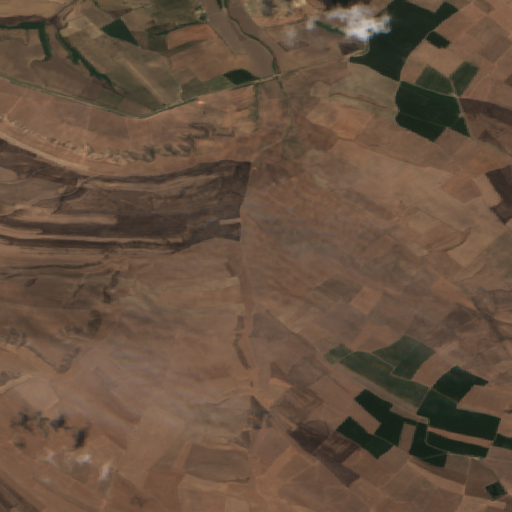

In [71]:
from IPython.display import Image

# Enter path to the image you want to display
Image(filename="image_folder/sample_image.png")

### Automated Processing

These were the underlying steps until now. The function `process_single_event` is designed to handle the full workflow of processing a single fire event based on its location and acquisition date.

In [72]:
dpl.process_single_event(sample_event, output_folder) # Process a single event/row from the csv file

Saved: image_folder/39.42647_48.25354_2024-07-13.png


'image_folder/39.42647_48.25354_2024-07-13.png'

The `process_event_batch function` is designed to process multiple fire events concurrently, using a thread pool to speed up the processing of a batch of fire data.

In [ ]:
dpl.process_event_batch(df, output_folder, max_workers=5) # Process the whole csv file automatically

You can optionally uncomment the code below to create a ZIP archive of the generated image folder for easy downloading and removal from the directory when needed.

In [ ]:
# !zip -r MODIS_Images_2024.zip MODIS_Images_2024

In [ ]:
# import shutil

# Specify the folder to remove
# folder_to_remove = 'SUOMI_VIIRS_IMAGES_2023'

# Remove the folder and its contents
# shutil.rmtree(folder_to_remove)
# print(f"Folder '{folder_to_remove}' and its contents have been removed.")